In [1]:
import pandas as pd
import re
import numpy as np
from plotnine import *
from datetime import timedelta
from scipy import stats
from sklearn.linear_model import PoissonRegressor
pd.set_option('display.max_rows', 500)

### Data Cleaning
* Convert size to a number
* `unit_of_measure` --> lower
* added rows for zeroes and estimated prices for those rows

In [2]:
def remove_unit(size):
    m = [x.group() for x in re.finditer(r'\d+', size)]
    assert len(m) <= 1
    if len(m) == 0:
        return np.nan
    return float(m[0])

In [3]:
sales = pd.read_csv('dairy_sales - dairy_sales.csv', parse_dates=['date'])
sales = sales.rename({'_size': 'size'}, axis=1)
sales['size'] = sales['size'].str.strip()
sales['size'] = sales['size'].apply(lambda x: remove_unit(str(x)))
sales['unit_of_measure'] = sales['unit_of_measure'].str.lower()

In [4]:
dates = sales['date'].unique()
list_upcs = list(sales['upc'].unique())
index = pd.MultiIndex.from_product([dates, list_upcs], names = ["date", "upc"])

zeroes = pd.DataFrame(index = index).reset_index()
zeroes['quantity_sold'] = 0

full_data = pd.concat([sales, zeroes]).drop_duplicates(subset=['date','upc'])  # keeps first
full_data.head()

,date,upc,description,quantity_sold,price,unit_cost,size,unit_of_measure
0,2021-01-01,74236526425,hrzn milk 2% uht og2,1,6.99,4.00,64.0,ea
1,2021-01-01,74236526402,hrzn milk lactose free,1,6.99,5.39,64.0,oz
2,2021-01-01,2640041035,drgld bulgarian bttrmilk,1,2.99,1.36,NaN,NaN
3,2021-01-01,4190007641,dairy pure whole milk 64 z,8,2.99,2.33,64.0,oz
4,2021-01-01,4190007663,viva 1/2 gal 2% milk,3,2.99,2.26,64.0,NaN


In [5]:
price_var = pd.DataFrame(full_data.groupby('upc')['price'].var())
upc_price_change = list(price_var[price_var['price']>0].index)
full_data = full_data.sort_values(['date','upc']).reset_index(drop=True)

In [6]:
temp = sales[(sales['upc']==81363602188) & (sales['price'])]
delta = temp['price'].diff()
delta_temp = list(delta[delta != 0].index)
initial_price = sales.iloc[temp.index[list(temp.index).index(delta_temp[0])-1]]['price']
sales.iloc[delta_temp][['date','price']]

,date,price
10,2021-01-02,6.99
1788,2021-07-04,4.99
1854,2021-07-08,6.99
3470,2021-11-07,5.59
3500,2021-11-10,6.99


In [7]:
price_change_dict = {}
min_time = sales['date'].min()
for upc in upc_price_change:
    temp = sales[(sales['upc']==upc) & (sales['price'])]
    delta = temp['price'].diff()
    delta_temp = list(delta[delta != 0].index)
    if len(delta_temp)==0:
        continue
    initial_price = sales.iloc[temp.index[list(temp.index).index(delta_temp[0])-1]]['price']
    changes = sales.iloc[delta_temp][['date','price']].reset_index(drop=True)
    
    price_dict = {min_time: initial_price}
    for change in range(changes.shape[0]):
        row = changes.iloc[change]
        price_dict[row['date']] = row['price']
    price_change_dict[upc] = price_dict

In [8]:
def get_price(x):
    if not np.isnan(x['price']):
        return x['price']
    if x['upc'] in upc_price_change:
        d = price_change_dict[x['upc']]
        value = None
        for k, v in d.items():
            if x['date'] >= k:
                value = v
        return value
    return full_data[(full_data['upc']==x['upc']) & full_data['price']].iloc[-1]['price']

In [9]:
full_data['new_price'] = full_data.apply(lambda x: get_price(x), axis=1)

In [10]:
full_data['profit'] = full_data['price'] - full_data['unit_cost']
full_data['day'] = full_data['date'].apply(lambda x: x.strftime('%A'))
full_data.head()

,date,upc,description,quantity_sold,price,unit_cost,size,unit_of_measure,new_price,profit,day
0,2021-01-01,1570010320,NaN,0,NaN,NaN,NaN,NaN,0.49,NaN,Friday
1,2021-01-01,1570012220,NaN,0,NaN,NaN,NaN,NaN,3.49,NaN,Friday
2,2021-01-01,1570012225,NaN,0,NaN,NaN,NaN,NaN,3.49,NaN,Friday
3,2021-01-01,1570014801,NaN,0,NaN,NaN,NaN,NaN,2.49,NaN,Friday
4,2021-01-01,1570015721,NaN,0,NaN,NaN,NaN,NaN,4.49,NaN,Friday


In [11]:
product = full_data.groupby('upc')
q_by_milk = product.sum()['quantity_sold']
q_by_milk.describe()

count      81.000000
mean      204.111111
std       380.417435
min         2.000000
25%        14.000000
50%        78.000000
75%       171.000000
max      2463.000000
Name: quantity_sold, dtype: float64

### Problem Statement
We would like to create a data-driven ordering system for a store’s dairy department. Design and implement a proof-of-concept (in Python), given sample sales data from a single store. 

1. **approaches you considered / why you chose your proposed approach**
    * I chose Markov decision processes because I have used them to construct simple inventory policy models before in stochastic modeling or reinforcement learning classes. I chose to use poisson regression to predict quantity sold in a day by UPC (instead of just computing the means for each UPC) to account for additional data like price. I could add info like brand if that were given. I chose not to use day of the week since the magnitudes of the predictions did not differ considerably, and including it would expand the state space. The optimal policy pertains to each UPC individually, not the whole. I would like more info on shipping costs to model a policy for overall order shipments.
2. **how you would evaluate the performance of the ordering system**
    * I would collect data on actual "reward" to see whether it aligns with expected reward, and adjust the reward functions and/or distribution for the probability of traveling to another state accordingly
3. **if there are limitations to when this solution applies**
    * This is a more complicated scenario than toy MDPs since I have to estimate the distributions for the transition probability matrix, and it is difficult to capture relationships between products without dramatically expanding the state space. I made some simplifying assumptions since additional data would be required, including:
        * the model is Markovian, so it ignores seasonality or time effects. I could accomodate the time series by using an autoregressive count regression, but I would take a little more time to learn how to do this in python.
        * Poisson regression assumes the counts satisfy a true poisson distribution; a better fit could probably be obtained with a zero-inflated or quasi-poisson model.
        * did not account for product substition; if a product is out of stock, the customer buys nothing
        * the model makes assumptions where no data is given; for example, product ordered at the end of the day today arrives by tomorrow morning with probability 1
4. **what additional data would you try to collect to improve the results?**
    * This model requires inventory by expiration date for each UPC, expiration dates of product that can be ordered, shipping costs (fixed and by unit), days until the shipment arrives, and some sense of the subjective penalties for food waste and having an item out of stock.
    * Other info that would be nice to have is: data from multiple stores with the same products to estimate product substitutability
5. **what might you propose as next steps?**
    * Find an overall strategy for ordering, with more shipping info
    * I would try to relax some of the above assumptions and find a better regression model.
    * If the distribution is a poor fit, I could consider RL models that don't require a transition probability matrix

### Exploratory data analysis

In [12]:
q_mean = pd.DataFrame(product['quantity_sold'].mean())
q_var = pd.DataFrame(product['quantity_sold'].var())
q_pois = q_mean.merge(q_var, right_index=True, left_index=True)
q_pois.columns = ['mean', 'var']
q_pois['diff'] = abs(q_pois['mean'] - q_pois['var'])/q_pois['mean']
q_pois.describe()

,mean,var,diff
count,81.000000,81.000000,81.000000
mean,0.311620,0.648008,0.837855
std,0.580790,1.237796,0.811996
min,0.003053,0.003049,0.001529
25%,0.021374,0.037832,0.276977
50%,0.119084,0.186404,0.591349
75%,0.261069,0.480412,1.089521
max,3.760305,7.289553,5.418158


/Users/madisonlindsay/.pyenv/versions/3.8.5/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 26'. Pick better value with 'binwidth'.


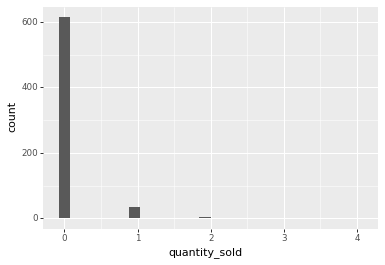

<ggplot: (305219124)>

In [13]:
(ggplot(full_data[full_data['upc']==1570012220].groupby('date').sum(), aes(x='quantity_sold'))
 + geom_histogram()
)

/Users/madisonlindsay/.pyenv/versions/3.8.5/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 24'. Pick better value with 'binwidth'.


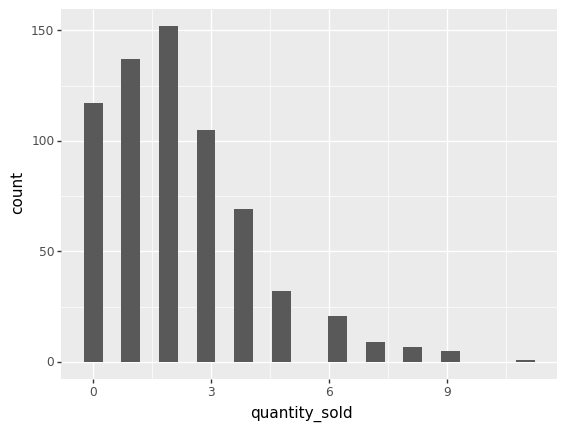

<ggplot: (304958440)>

In [14]:
(ggplot(full_data[full_data['upc']==74236526425].groupby('date').sum(), aes(x='quantity_sold'))
 + geom_histogram()
)

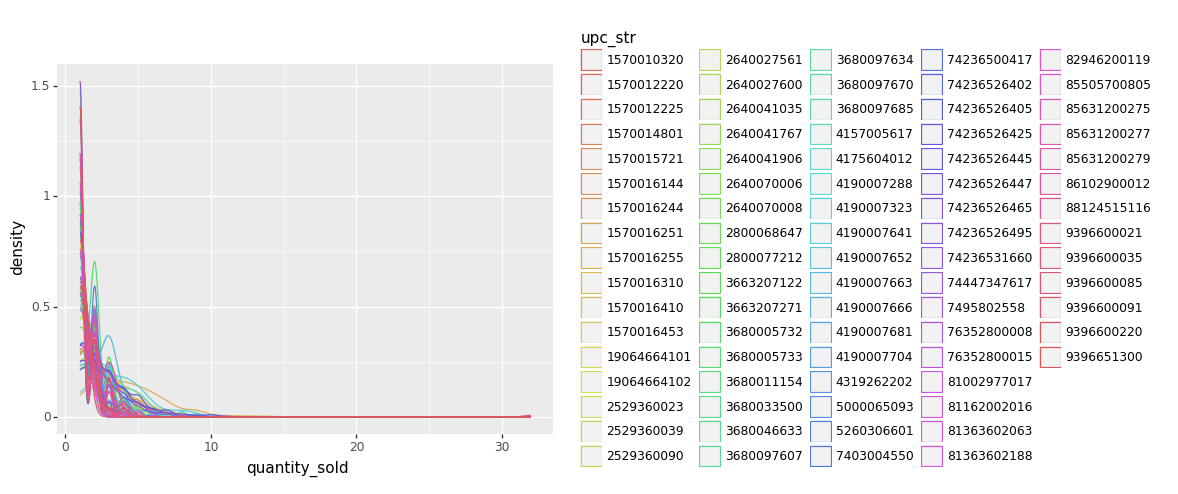

<ggplot: (305211064)>

In [15]:
full_data['upc_str'] = full_data['upc'].astype(str)
(ggplot(full_data[full_data['quantity_sold']>0]#[full_data['upc'].isin([74236526425,85631200275])]
        , aes(x='quantity_sold', color='upc_str'))
 + geom_density()
)

/Users/madisonlindsay/.pyenv/versions/3.8.5/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 21'. Pick better value with 'binwidth'.


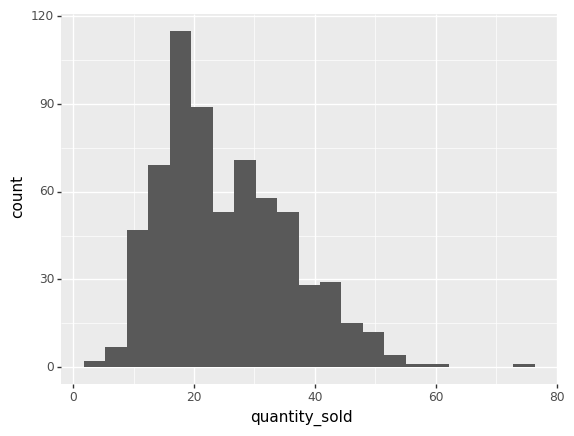

<ggplot: (305776147)>

In [16]:
(ggplot(full_data.groupby('date').sum(), aes(x='quantity_sold'))
 + geom_histogram()
)

In [17]:
full_data.groupby(['day', 'upc']).mean()

quantity_sold     price  unit_cost  size  new_price  \
day       upc                                                                
Friday    1570010320        0.446809  0.490000   0.264286   8.0   0.490000   
          1570012220        0.085106  3.490000   1.328571  32.0   3.490000   
          1570012225        0.021277  3.490000   1.970000  32.0   3.490000   
          1570014801        1.542553  2.490000   1.332830  32.0   2.490000   
          1570015721        0.053191  4.490000   2.494000  64.0   4.490000   
...                              ...       ...        ...   ...        ...   
Wednesday 85631200275       0.075269  5.823333   3.663333  52.0   5.957742   
          85631200277       0.483871  5.550000   3.345333  52.0   5.655591   
          85631200279       0.623656  5.698571   3.347714  52.0   5.700753   
          86102900012       0.032258  8.490000   5.100000  28.0   8.490000   
          88124515116       0.000000       NaN        NaN   NaN   7.990000   

                         profit  
day       upc                    
Friday    1570010320   0.225714  
          1570012220   2.161429  
          1570012225   1.520000  
          1570014801   1.157170  
          1570015721   1.996000  
...                         ...  
Wednesday 85631200275  2.160000  
          85631200277  2.204667  
          85631200279  2.350857  
          86102900012  3.390000  
          88124515116       NaN  

[567 rows x 6 columns]

In [18]:
# (ggplot(full_data, aes(x='price',y='quantity_sold'))
#  + geom_jitter()
# )

In [19]:
#price_change = full_data[(full_data['upc'].isin(upc_price_change)) & (full_data['price'])]
# pd.DataFrame(price_change.groupby('upc')['price'].min()).merge(
#     price_change.groupby('upc')['price'].max(), left_index=True, right_index=True
# )

In [20]:
#full_data[(full_data['upc'].isin(upc_price_change)) & (full_data['price'])]

### Regression
* Poisson regression to estimate the mean of the distribution for each product
* Could be better than taking the means individually since products with small sample sizes may be similarly distributed to one another, given more data collection. This way, additional variables like price and maybe day of the week can be considered.
* I did not spend much time trying to improve this model; normally I would split into test/train sets, perform feature selection, and evaluate predictor significance

In [21]:
pr = PoissonRegressor(max_iter=100000)
x = full_data[['new_price','upc']]
#x['upc'] = x['upc'].astype('category')
#x = x.merge(pd.get_dummies(x['day']).drop('Monday', axis=1), left_index=True, right_index=True).drop('day',axis=1)
x = x.merge(pd.get_dummies(x['upc']).drop(1570010320,axis=1),left_index=True, right_index=True).drop('upc',axis=1)
y = full_data['quantity_sold']
pr.fit(x,y)

PoissonRegressor(max_iter=100000)

In [23]:
# print(pr.intercept_)
# pr.coef_
# pr.score(x,y)

In [24]:
y_pred = pr.predict(x)
full_data['y_pred'] = y_pred

In [25]:
# pred for most recent price
upc_pred = full_data[['upc','y_pred']].drop_duplicates('upc', keep='last').reset_index(drop=True)

In [26]:
upc_pred.head()

,upc,y_pred
0,1570010320,0.486080
1,1570012220,0.353182
2,1570012225,0.352930
3,1570014801,0.398562
4,1570015721,0.317900


These results demonstrate that day of the week does not significantly change expected number of products sold on a given day. Want to calculate probability that one item is sold today, two items, three, and so on.

## Markovian model
State space = # of products in inventory (Z+) for each UPC. I truncate the state space to 10 items for simplicity, and this number can be easily adjusted. The probability of moving from 5 items one day to 4 the next comes from the estimated Poisson distribution for each product. The action space (a function of state space) is the number of items ordered in a state. Below, I:
* construct a transition probability matrix, dependent on the policy (action vector)
* compute expected cost, making a lot of assumptions about what those costs might be
* create a dictionary storing initialized values for each UPC

In [27]:
def transition_matrix(v, a, one_row=None, a_one_row=None):
    # a = number to reach post-order
    # assuming order is placed in the evening and arrives the next morning with probability 1
    v = v[::-1]
    if one_row is not None:
        m = np.zeros(n)
        m[0:one_row+1+a_one_row] = v[n-(one_row+1+a_one_row):n]
        m[0] = 1 - np.sum(v[n-(one_row+1+a_one_row)+1:n])
        return m
    m = np.zeros((n,n))
    for row in range(n):
        m[row,0:row+1+a[row]] = v[n-(row+1+a[row]):n]
        m[row,0] = 1 - np.sum(v[n-(row+1+a[row])+1:n])
    sum_to_one = (np.round(np.sum(m, axis=1),7) == np.ones(n))
    assert all(sum_to_one), f'Matrix is not stochastic in row {np.where(np.any([not x for x in sum_to_one]))[0]}!\n{m}'
    return m

In [28]:
def e_products_wasted(s, mu):
    return mu*(1-stats.poisson.cdf(s-1, mu)) - s*(1-stats.poisson.cdf(s, mu))

# d = days until expiration
def food_waste_cost(current_inventory, days):
    actions = [0 for x in range(len(v))]  # ordering new product does not affect current product
    expiration_mat = transition_matrix(v, actions)
    prob_of_x_products = np.linalg.matrix_power(expiration_mat, days)[current_inventory,:]
    #print(prob_of_x_products)
    prod_value = np.array(range(n))
    food_waste = waste_penalty * np.dot(prob_of_x_products, prod_value)
    return food_waste

def e_product_sold(s, mu):
    return mu * stats.poisson.cdf(s-1, mu)

def e_reward(profit, s, mu, a, unit_cost):
    costs = food_waste_cost(s,days) + out_of_stock[s] + ship_cost*(a[s]>0) - a[s]*unit_cost
    return (profit+unit_cost) * e_product_sold(s, mu)*10 + costs

In [34]:
n = 10  # max inventory
counts = np.arange(n)
predict_prob = stats.poisson.pmf(counts, np.asarray(upc_pred['y_pred'])[:, None])
a = [7,6,5,4,3,2,1,0,0,0]
assert len(a) == n
oos_penalty = -0.13
waste_penalty = -0.25
days = 5  # days until expiration is FIXED for all products and items
ship_cost = -2
gamma = 0.9

upc_dict = {}
for upc in upc_pred['upc']:
    try:
        profit = full_data[(full_data['upc'] == upc) & ~np.isnan(full_data['profit'])]['profit'].iloc[-1]
        unit_cost = full_data[(full_data['upc'] == upc) & ~np.isnan(full_data['unit_cost'])]['unit_cost'].iloc[-1]
    except:
        print(f'missing for {upc}')
    idx = upc_pred[upc_pred['upc'] == upc].index
    v = predict_prob[idx][0]
    P_pi = transition_matrix(v, a)
    
    mu = float(upc_pred.iloc[idx]['y_pred'])
    out_of_stock = [oos_penalty * e_products_wasted(s, mu) for s in range(n)]
    
    # expected reward for current policy in each inventory state
    R_pi = np.array([e_reward(profit, s, mu, a, unit_cost) for s in range(n)])
    V_pi = np.dot(np.linalg.inv(np.identity(n)-gamma*P_pi), R_pi)
    upc_dict[upc] = {'P_pi': P_pi, 'R_pi': R_pi, 'V_pi': V_pi, 'v': v, 'mu': mu, 'a': a,
                     'profit': profit, 'unit_cost': unit_cost}

missing for 2640027561
missing for 3680097607
missing for 3680097670
missing for 3680097685
missing for 9396600035
missing for 88124515116


## MDP
Interpret the solution in the "policy" column below where the position in the vector, starting at zero, is the # of items in stock, and the number in the vector is the number of items that should be ordered in that state. For example, in the UPC table below, UPC = 3663207122 recommends ordering 3 items in state 0, 2 in state 1, 1 in state 2, and zero otherwise.
* compute a p-matrix for a given action vector
* compute the expected reward and value of each state given a policy
* iterate through policies, maximizing reward over actions, until the policy converges

In [30]:
def get_p_dict(v, a):
    p_dict = {x: {} for x in range(n)}
    for s in range(n):
        temp_a = [x for x in a]
        for act in range(n-s):
            temp_a[s] = act
            p_dict[s][act] = transition_matrix(v, temp_a)
    return p_dict

In [31]:
def get_v_pi(d, P_pi, s, act):
    temp_a = [x for x in d['a']]
    temp_a[s] = act
    R_pi = np.array([e_reward(d['profit'], s, d['mu'], temp_a, d['unit_cost']) for s in range(n)])
    V_pi = np.dot(np.linalg.inv(np.identity(n)-gamma*P_pi), R_pi)
    return R_pi[s] + gamma * np.dot(P_pi[s,:], V_pi)

In [32]:
def policy_improvement(upc, max_iter=100):
    d = upc_dict[upc]
    iterations = 0
    #print(d['a'])
    while True:
        stable = True
        p_dict = get_p_dict(d['v'], d['a'])
        pi = []
        for s in range(n):
            old_action = d['a'][s]
            values = [get_v_pi(d, p_dict[s][act], s, act) for act in range(n-s)]
            argmax = [x for x in range(len(values)) if values[x] == max(values)]
            if old_action in argmax:
                pi.append(old_action)
            else:
                pi.append(argmax[0])
            if old_action != pi[s]:
                stable = False
        d['a'] = [x for x in pi]
        #print(pi)
        if stable:
            return pi
        
        iterations += 1
        if iterations >= max_iter:
            print(f'UPC {upc} did not converge!')
            return pi

In [33]:
policy_improvement(2529360023) #74447347617 74236526495

[3, 2, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
upc_pred['policy'] = upc_pred['upc'].apply(lambda x: policy_improvement(x))

In [36]:
upc_pred

,upc,y_pred,policy
0,1570010320,0.486080,"[4, 3, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1570012220,0.353182,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
2,1570012225,0.352930,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
3,1570014801,0.398562,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
4,1570015721,0.317900,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
5,1570016144,0.309693,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
6,1570016244,0.376212,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
7,1570016251,0.376106,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
8,1570016255,0.389446,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
9,1570016310,0.397860,"[4, 3, 2, 0, 0, 0, 0, 0, 0, 0]"
